## Categorizing US counties

In [2]:
import pandas as pd

### Import county category data
Source: NCHS Urban-Rural Classification Scheme for Counties

##### The NCHS has developed a six-level urban-rural classification scheme for U.S. counties and county-equivalent entities.
1. Metropolitan counties: Large central metro counties in MSA of 1 million population that: 1) contain the entire population of the largest principal city of the MSA, or 2) are completely contained within the largest principal city of the MSA, or 3) contain at least 250,000 residents of any principal city in the MSA.
2. Large fringe metro counties in MSA of 1 million or more population that do not qualify as large central 
3. Medium metro counties in MSA of 250,000-999,999 population.
4. Small metro counties are counties in MSAs of less than 250,000 population.
5. Micropolitan counties in micropolitan statistical area
6. Noncore counties not in micropolitan statistical areas
    
##### We can farther collapse these six categories into urban, suburban, and rural:
- Urban: 1 (Large central metro)
- Suburban: 2, 3, 4 (Large fringe metro counties, medium metro, and small metro counties)
- Rural: 5 and 6 (Micropolitan counties and Noncore counties)
    

In [3]:
county_categories = pd.read_excel("NCHSURCodes2013.xlsx")
print(county_categories.shape)
county_categories.head()

(3149, 9)


,FIPS code,State Abr.,County name,CBSA title,CBSA 2012 pop,County 2012 pop,2013 code,2006 code,1990-based code
0,1001,AL,Autauga County,"Montgomery, AL",377149,55514,3,3,3
1,1003,AL,Baldwin County,"Daphne-Fairhope-Foley, AL",190790,190790,4,5,3
2,1005,AL,Barbour County,NaN,.,27201,6,5,5
3,1007,AL,Bibb County,"Birmingham-Hoover, AL",1136650,22597,2,2,6
4,1009,AL,Blount County,"Birmingham-Hoover, AL",1136650,57826,2,2,3


In [4]:
selected = county_categories[["FIPS code", "2013 code"]]
selected.astype({"FIPS code": "int64"})
selected.head()

,FIPS code,2013 code
0,1001,3
1,1003,4
2,1005,6
3,1007,2
4,1009,2


### Import County-level Covid Data
Source: NY Times (https://github.com/nytimes/covid-19-data)

In [5]:
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

covid_by_counties = pd.read_csv(url, error_bad_lines=False)

print(covid_by_counties.shape)
covid_by_counties.head()

(1154137, 6)


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


### Merging and Fixing

The first merge attempt shows that three of the counties in this dataset do not come with fips county code that identifies them. They are New York City, Kansas City, and Joplin. 

We will fill in the fips code for New York City with that of New York County because they generally refer to the same region. 

Joplin (Missouri) is a city in both Jasper and Newton County. Since both are designated by the NCHS system as small metro counties and Joplin is mostly in Jasper County, we will fill in the Joplin FIPS code with the Jasper County FIPS code.

Kansas City (Missouri) straddles the Kansas-Missouri state line. The bulk of it is in Jackson County, Missouri, but parts of it lie in Clay, Cass, and Platte Counties. We will fill in the Kansas City FIPS with that of Jackson County.

In [6]:
with_categories_left_1 = pd.merge(covid_by_counties, selected, left_on = "fips", right_on = "FIPS code", how = "left")
print(with_categories_left_1.shape)
with_categories_left_1[with_categories_left_1["fips"].isnull()].groupby("county").sum()

(1154137, 8)


,fips,cases,deaths,FIPS code,2013 code
county,,,,,
Joplin,0.0,720651,13614.0,0.0,0.0
Kansas City,0.0,5601586,70084.0,0.0,0.0
New York City,0.0,119460656,8295526.0,0.0,0.0
Unknown,0.0,12939747,543215.0,0.0,0.0


In [7]:
covid_by_counties.loc[covid_by_counties["county"] == "New York City", "fips"] = 36061
covid_by_counties.loc[covid_by_counties["county"] == "Joplin", "fips"] = 29097
covid_by_counties.loc[covid_by_counties["county"] == "Kansas City", "fips"] = 29095

In [8]:
with_categories_left_2 = pd.merge(covid_by_counties, selected, left_on = "fips", right_on = "FIPS code", how = "left")
print(with_categories_left_2.shape)
with_categories_left_2[with_categories_left_2["fips"].isnull()].groupby("county").sum()

(1154137, 8)


,fips,cases,deaths,FIPS code,2013 code
county,,,,,
Unknown,0.0,12939747,543215.0,0.0,0.0


In [9]:
print(with_categories_left_2[with_categories_left_2["fips"].isnull()].shape[0])
print(with_categories_left_2[with_categories_left_2["fips"].isnull()].shape[0]/with_categories_left_2.shape[0])
print(with_categories_left_2[with_categories_left_2["fips"].isnull()].groupby("state").sum().shape)
print(with_categories_left_2[with_categories_left_2["fips"].isnull() == False].groupby("state").sum().shape)

9540
0.00826591643799653
(53, 5)
(54, 5)


After fixing the fips codes above, we are only missing county information on 9257 entries in the 1118423-entry dataset. That is only 0.83% of the data. We also check to make sure all 50 states are represented in our dataset.

### Dividing into Urban, Suburban, and Rural

In [10]:
with_categories_left_2.loc[with_categories_left_2["2013 code"] == 1, "category"] = "Urban"
with_categories_left_2.loc[with_categories_left_2["2013 code"] == 2, "category"] = "Suburban"
with_categories_left_2.loc[with_categories_left_2["2013 code"] == 3, "category"] = "Suburban"
with_categories_left_2.loc[with_categories_left_2["2013 code"] == 4, "category"] = "Suburban"
with_categories_left_2.loc[with_categories_left_2["2013 code"] == 5, "category"] = "Rural"
with_categories_left_2.loc[with_categories_left_2["2013 code"] == 6, "category"] = "Rural"

In [11]:
with_categories_left_2.head()

,date,county,state,fips,cases,deaths,FIPS code,2013 code,category
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,53061.0,2.0,Suburban
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,53061.0,2.0,Suburban
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,53061.0,2.0,Suburban
3,2020-01-24,Cook,Illinois,17031.0,1,0.0,17031.0,1.0,Urban
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0,53061.0,2.0,Suburban


### Import College Data

In [61]:
college_url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/colleges/colleges.csv"

covid_by_college = pd.read_csv(college_url, error_bad_lines=False)

print(covid_by_college.shape)
covid_by_college.head()


(1949, 9)


,date,state,county,city,ipeds_id,college,cases,cases_2021,notes
0,2021-02-26,Alabama,Madison,Huntsville,100654,Alabama A&M University,41,NaN,NaN
1,2021-02-26,Alabama,Montgomery,Montgomery,100724,Alabama State University,2,NaN,NaN
2,2021-02-26,Alabama,Limestone,Athens,100812,Athens State University,45,10.0,NaN
3,2021-02-26,Alabama,Lee,Auburn,100858,Auburn University,2499,324.0,NaN
4,2021-02-26,Alabama,Montgomery,Montgomery,100830,Auburn University at Montgomery,214,74.0,NaN


### Import total county cases data

In [13]:
county_total_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv'
covid_by_county_total = pd.read_csv(county_total_url, error_bad_lines=False)
print(covid_by_county_total.shape)
covid_by_county_total.head()

(3248, 10)


,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2021-03-25,Autauga,Alabama,1001.0,6540,99.0,5598.0,88.0,942.0,11.0
1,2021-03-25,Baldwin,Alabama,1003.0,20417,300.0,14482.0,222.0,5935.0,78.0
2,2021-03-25,Barbour,Alabama,1005.0,2218,54.0,1236.0,35.0,982.0,19.0
3,2021-03-25,Bibb,Alabama,1007.0,2534,58.0,2049.0,35.0,485.0,23.0
4,2021-03-25,Blount,Alabama,1009.0,6408,131.0,4937.0,110.0,1471.0,21.0


### Merging and Fixing College Data with County Data

In [88]:
college_merge_with_county = covid_by_county_total.merge(covid_by_college, on = ['county','state'], how = 'outer')
college_merge_with_county = college_merge_with_county.merge(county_categories, left_on = 'fips', right_on = 'FIPS code')
college_merge_with_county = college_merge_with_county.drop(columns = ['CBSA title', '1990-based code', '2006 code', 'County name','State Abr.','FIPS code','cases_2021','notes','CBSA 2012 pop', 'date_y', 'city'])
college_merge_with_county = college_merge_with_county.rename({'cases_x': 'county_cases', 'cases_y': 'college_cases', 'date_x':'Date'}, axis=1)
college_merge_with_county['infection_rate'] = college_merge_with_county['county_cases']/college_merge_with_county['County 2012 pop']
print(college_merge_with_county.shape)

college_merge_with_county.head()


(4012, 16)


,Date,county,state,fips,county_cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,ipeds_id,college,college_cases,County 2012 pop,2013 code,infection_rate
0,2021-03-25,Autauga,Alabama,1001.0,6540.0,99.0,5598.0,88.0,942.0,11.0,NaN,NaN,NaN,55514,3,0.117808
1,2021-03-25,Baldwin,Alabama,1003.0,20417.0,300.0,14482.0,222.0,5935.0,78.0,NaN,NaN,NaN,190790,4,0.107013
2,2021-03-25,Barbour,Alabama,1005.0,2218.0,54.0,1236.0,35.0,982.0,19.0,NaN,NaN,NaN,27201,6,0.0815411
3,2021-03-25,Bibb,Alabama,1007.0,2534.0,58.0,2049.0,35.0,485.0,23.0,NaN,NaN,NaN,22597,2,0.112139
4,2021-03-25,Blount,Alabama,1009.0,6408.0,131.0,4937.0,110.0,1471.0,21.0,NaN,NaN,NaN,57826,2,0.110815


In [89]:
import seaborn as sns

In [131]:
county_no_college = college_merge_with_county[college_merge_with_county['college_cases'].isna()]
county_no_college['has_college'] = False
print(len(county_no_college))
county_with_college = college_merge_with_county[college_merge_with_county['college_cases'].notna()]
county_with_college['has_college'] = True
print(len(county_with_college))
temp = county_with_college.groupby(['state','county'])

with_college_infection_rate = temp['infection_rate','has_college'].first()

with_college_infection_rate.head()

2193
1819


<ipython-input-131-7c79afb3ad51>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_no_college['has_college'] = False
<ipython-input-131-7c79afb3ad51>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_with_college['has_college'] = True
<ipython-input-131-7c79afb3ad51>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  with_college_infection_rate = temp['infection_rate','has_college'].first()


infection_rate  has_college
state   county                                
Alabama Calhoun          0.120959         True
        Coffee           0.104737         True
        Covington        0.106257         True
        Etowah           0.130556         True
        Houston          0.099418         True

In [133]:
temp = county_no_college.groupby(['state','county'])
no_college_infection_rate = temp['infection_rate','has_college'].first()
no_college_infection_rate.head()


<ipython-input-133-e0175e1d43ee>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  no_college_infection_rate = temp['infection_rate','has_college'].first()


infection_rate  has_college
state   county                              
Alabama Autauga        0.117808        False
        Baldwin        0.107013        False
        Barbour        0.081541        False
        Bibb           0.112139        False
        Blount         0.110815        False

In [136]:
combined_infection = pd.concat([with_college_infection_rate,no_college_infection_rate])
combined_infection.head()

infection_rate  has_college
state   county                                
Alabama Calhoun          0.120959         True
        Coffee           0.104737         True
        Covington        0.106257         True
        Etowah           0.130556         True
        Houston          0.099418         True

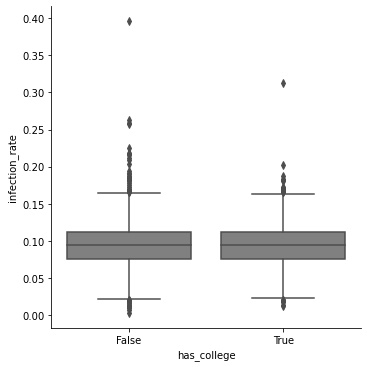

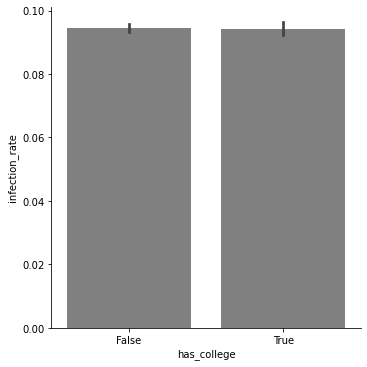

In [139]:
print(sns.catplot(x = 'has_college', y = 'infection_rate', data = combined_infection, kind = "box", color = 'grey'))
print(sns.catplot(x = 'has_college', y = 'infection_rate', data = combined_infection, kind = "bar", color = 'grey'))

